In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
# import warnings; warnings.simplefilter('ignore')
import os; os.environ['TF_CPP_MIN_LOG_LEVEL']='2'
import pandas as pd
# from avian_vocalizations.data import preprocess
from avian_vocalizations.data import AudioFeatureGenerator
from avian_vocalizations.model import CombinedModel #, MFCCModel, SgModel
from avian_vocalizations.training import train_model
from sklearn.preprocessing import LabelEncoder
import numpy as np
from matplotlib import pyplot as plt
from librosa.display import specshow
from datetime import datetime

In [5]:
index_df = pd.read_csv('../data/xeno-canto_ca-nv_stats.csv', index_col='file_id')
label_encoder = LabelEncoder().fit(index_df['english_cname'] )
n_classes = len(label_encoder.classes_)
train_df = index_df.loc[pd.read_csv('../data/train_file_ids.csv')['file_id']]

y_train = label_encoder.fit_transform(train_df['english_cname'])

In [6]:
X_train = train_df.index.values
X_train

array([453098, 344803, 355425, ..., 326580, 144072, 450763], dtype=int64)

In [7]:
n_frames = 1024

In [8]:
generator = AudioFeatureGenerator(X_train, y_train, data_dir='../data',
            batch_size=3, shuffle=True, seed=37, n_frames=n_frames, scale=True)
Xs, ys = generator[0]
Xs.keys()

dict_keys(['melsg', 'mfcc', 'id', 'offset'])

In [9]:
ys

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0]])

In [10]:
[label_encoder.classes_[np.argmax(y)] for y in ys]

['Western Wood Pewee', 'Common Poorwill', 'Hermit Thrush']

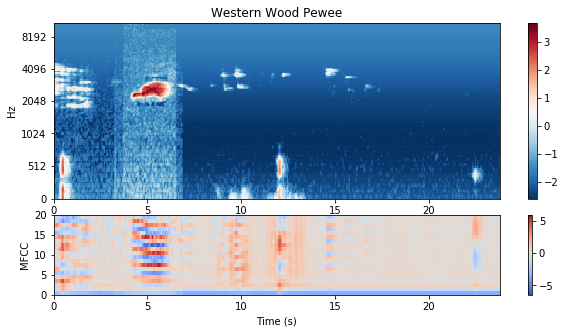

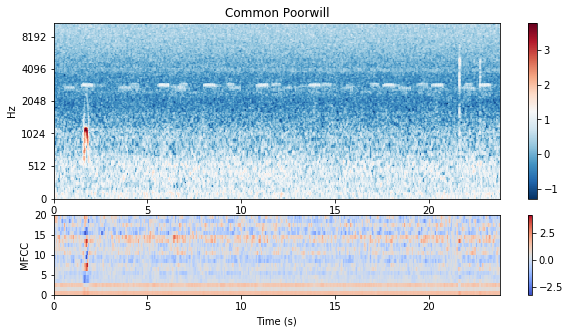

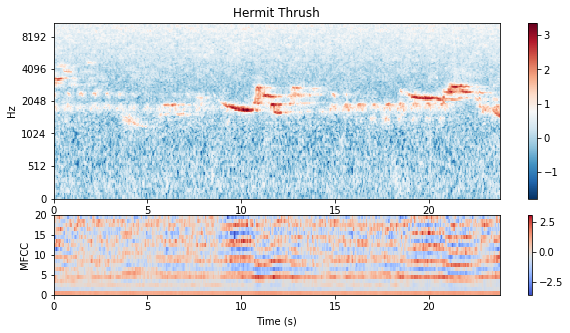

In [11]:
for i in range(3):
    gs = plt.GridSpec(3,1)
    fig = plt.figure(figsize=(10,5))
    msg_ax = fig.add_subplot(gs[:2])
    specshow(Xs['melsg'][i].reshape(Xs['melsg'][i].shape[:2]), 
             ax=msg_ax, x_axis='s', y_axis='mel', cmap='RdBu_r')
    plt.title(label_encoder.classes_[np.argmax(ys[i])])
    plt.colorbar(fig.gca().collections[0])
    mfcc_ax = fig.add_subplot(gs[2])
    specshow(Xs['mfcc'][i].reshape(Xs['mfcc'][i].shape[:2]),
             ax=mfcc_ax, x_axis='s')
    plt.yticks(range(0,21,5))
    plt.ylabel("MFCC")
    plt.colorbar(fig.gca().collections[0])
    plt.show()

In [12]:
Xs['mfcc'][0].shape, Xs['melsg'][0].shape

((20, 1024, 1), (128, 1024, 1))

In [13]:
model = CombinedModel(n_classes, n_frames=n_frames)
model.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
melsg (InputLayer)              (None, 128, 1024, 1) 0                                            
__________________________________________________________________________________________________
mfcc (InputLayer)               (None, 20, 1024, 1)  0                                            
__________________________________________________________________________________________________
sg_conv2d_1 (Conv2D)            (None, 126, 1022, 16 160         melsg[0][0]                      
__________________________________________________________________________________________________
mfcc_conv2d_1 (Conv2D)          (None, 20, 1022, 16) 64          mfcc[0][0]                       
__________

In [14]:
train_model(model, X_train, y_train, n_epochs=10, n_splits=1,
            n_frames=n_frames, batch_size=24, #validation_size=.25, seed=37,
            tensorboard_dir='../tensorboard/CombinedModel',
           )




Epoch 1/10
57/57 [==============================] - 27s 469ms/step - loss: 4.5143 - accuracy: 0.0088 - val_loss: 4.4573 - val_accuracy: 0.0176

Epoch 00001: val_loss improved from inf to 4.45732, saving model to training_example_output\weights.best.split00.hdf5

Epoch 2/10
57/57 [==============================] - 21s 376ms/step - loss: 4.4634 - accuracy: 0.0227 - val_loss: 4.2699 - val_accuracy: 0.0242

Epoch 00002: val_loss improved from 4.45732 to 4.26994, saving model to training_example_output\weights.best.split00.hdf5
Epoch 3/10
57/57 [==============================] - 21s 375ms/step - loss: 4.2809 - accuracy: 0.0462 - val_loss: 4.2647 - val_accuracy: 0.0527

Epoch 00003: val_loss improved from 4.26994 to 4.26466, saving model to training_example_output\weights.best.split00.hdf5
Epoch 4/10
57/57 [==============================] - 21s 376ms/step - loss: 4.0127 - accuracy: 0.0916 - val_loss: 4.0377 - val_accuracy: 0.0681

Epoch 00004: val_loss improved from 4.26466 to 4.03773, sa